# Offline Phase: GEIM algorithm
**Aim of the tutorial:** this notebook shows how to perform the offline phase of the GEIM algorithm, i.e. how to use this method to generate the magic functions and the associared magic sensors from a parametric dataset.

The only observable variable is assumed to be the temperature: *the GEIM class is only able to handle scalar variables at the moment*.

----

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable).

In [1]:
import numpy as np
import pickle
import os
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import Function, FunctionSpace

from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00111864s, CPU 0.000849s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.0187267s, CPU 0.007379s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 2.643e-06s, CPU 3e-06s)


Let us define the functional space onto which the OpenFOAM data have been projected; then, the snapshots can be imported.

Even if only a single variable (the temperature is analysed), `var_names` is defined as a list of strings, to help generalise the notebook.

In [3]:
path_FOM = './Snapshots/'

# The temperature is the only one that can be measured
var_names = ['norm_T']
tex_var_names = ['T']

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]

train_snaps = dict()

for field_i, field in enumerate(var_names):
    
    path_snap = path_FOM+'TrainSet_'+field
    train_snaps[field] = ImportH5(fun_spaces[field_i], path_snap, field)[0]

## GEIM algorithm

### Generation of the magic functions/sensors
The GEIM is used to generated through a greedy process a set of basis functions and basis sensors for the data assimilation process.

Sensors are mathematically modelled as linear continuous functionals $v_m(\cdot)$, defined as
\begin{equation*}
v_m(u(\mathbf{x});\,\mathbf{x}_m,\,s)=\int_\Omega u(\mathbf{x})\cdot \mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\,d\Omega
\end{equation*}
given $\mathbf{x}_m$ the centre of mass of the functional and $s$ its point spread. The current version adopts Gaussian kernels 
\begin{equation*}
\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right) = \frac{e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}}{\displaystyle\int_\Omega e^{\frac{-\|\mathbf{x}-\mathbf{x}_m\|_2^2}{2s^2}}\,d\Omega}
\end{equation*}
such that $\|\mathcal{K}\left(\|\mathbf{x}-\mathbf{x}_m\|_2, s\right)\|_{L^1(\Omega)}=1$, this models the measurement process of scalar fields.

In [4]:
from pyforce.offline.geim import GEIM

geim_data = dict()
train_GEIMcoeff = dict()
Mmax = 20

# This parameter serves as input to select only some cells in the mesh
sam_every = 5

s = 0.01

train_abs_err = np.zeros((Mmax, len(var_names)))
train_rel_err = np.zeros((Mmax, len(var_names)))

for field_i, field in enumerate(var_names):
    geim_data[field] = GEIM(domain, fun_spaces[field_i], field_i, s=s)
    tmp = geim_data[field].offline(train_snaps[field], Mmax, sampleEvery = sam_every, verbose = True)

    train_abs_err[:, field_i] = tmp[0].flatten()
    train_rel_err[:, field_i] = tmp[1].flatten()
    train_GEIMcoeff[field] = tmp[2]

Generating sensors (sampled every 5 cells): 3277.000 / 3277.00 - 0.008 s/it


Let us store the magic functions, the magic sensors and the training coefficients for later use.

In [5]:
path_offline = './Offline_results/'

if not os.path.exists(path_offline+'/BasisSensors/'):
    os.makedirs(path_offline+'/BasisSensors/')
if not os.path.exists(path_offline+'/BasisFunctions/'):
    os.makedirs(path_offline+'/BasisFunctions/')

pickle.dump(train_GEIMcoeff, open(path_offline+'coeffs.geim', 'wb'))

for field in var_names:    
    store(domain, geim_data[field].magic_fun,  'GEIM_' +field, path_offline+'/BasisFunctions/basisGEIM_' + field)
    store(domain, geim_data[field].magic_sens, 'GEIM_' +field, path_offline+'/BasisSensors/sensorsGEIM_' + field)

### Post-process: plotting magic functions and sensors
The magic functions and sensors are plotted using `pyvista`.

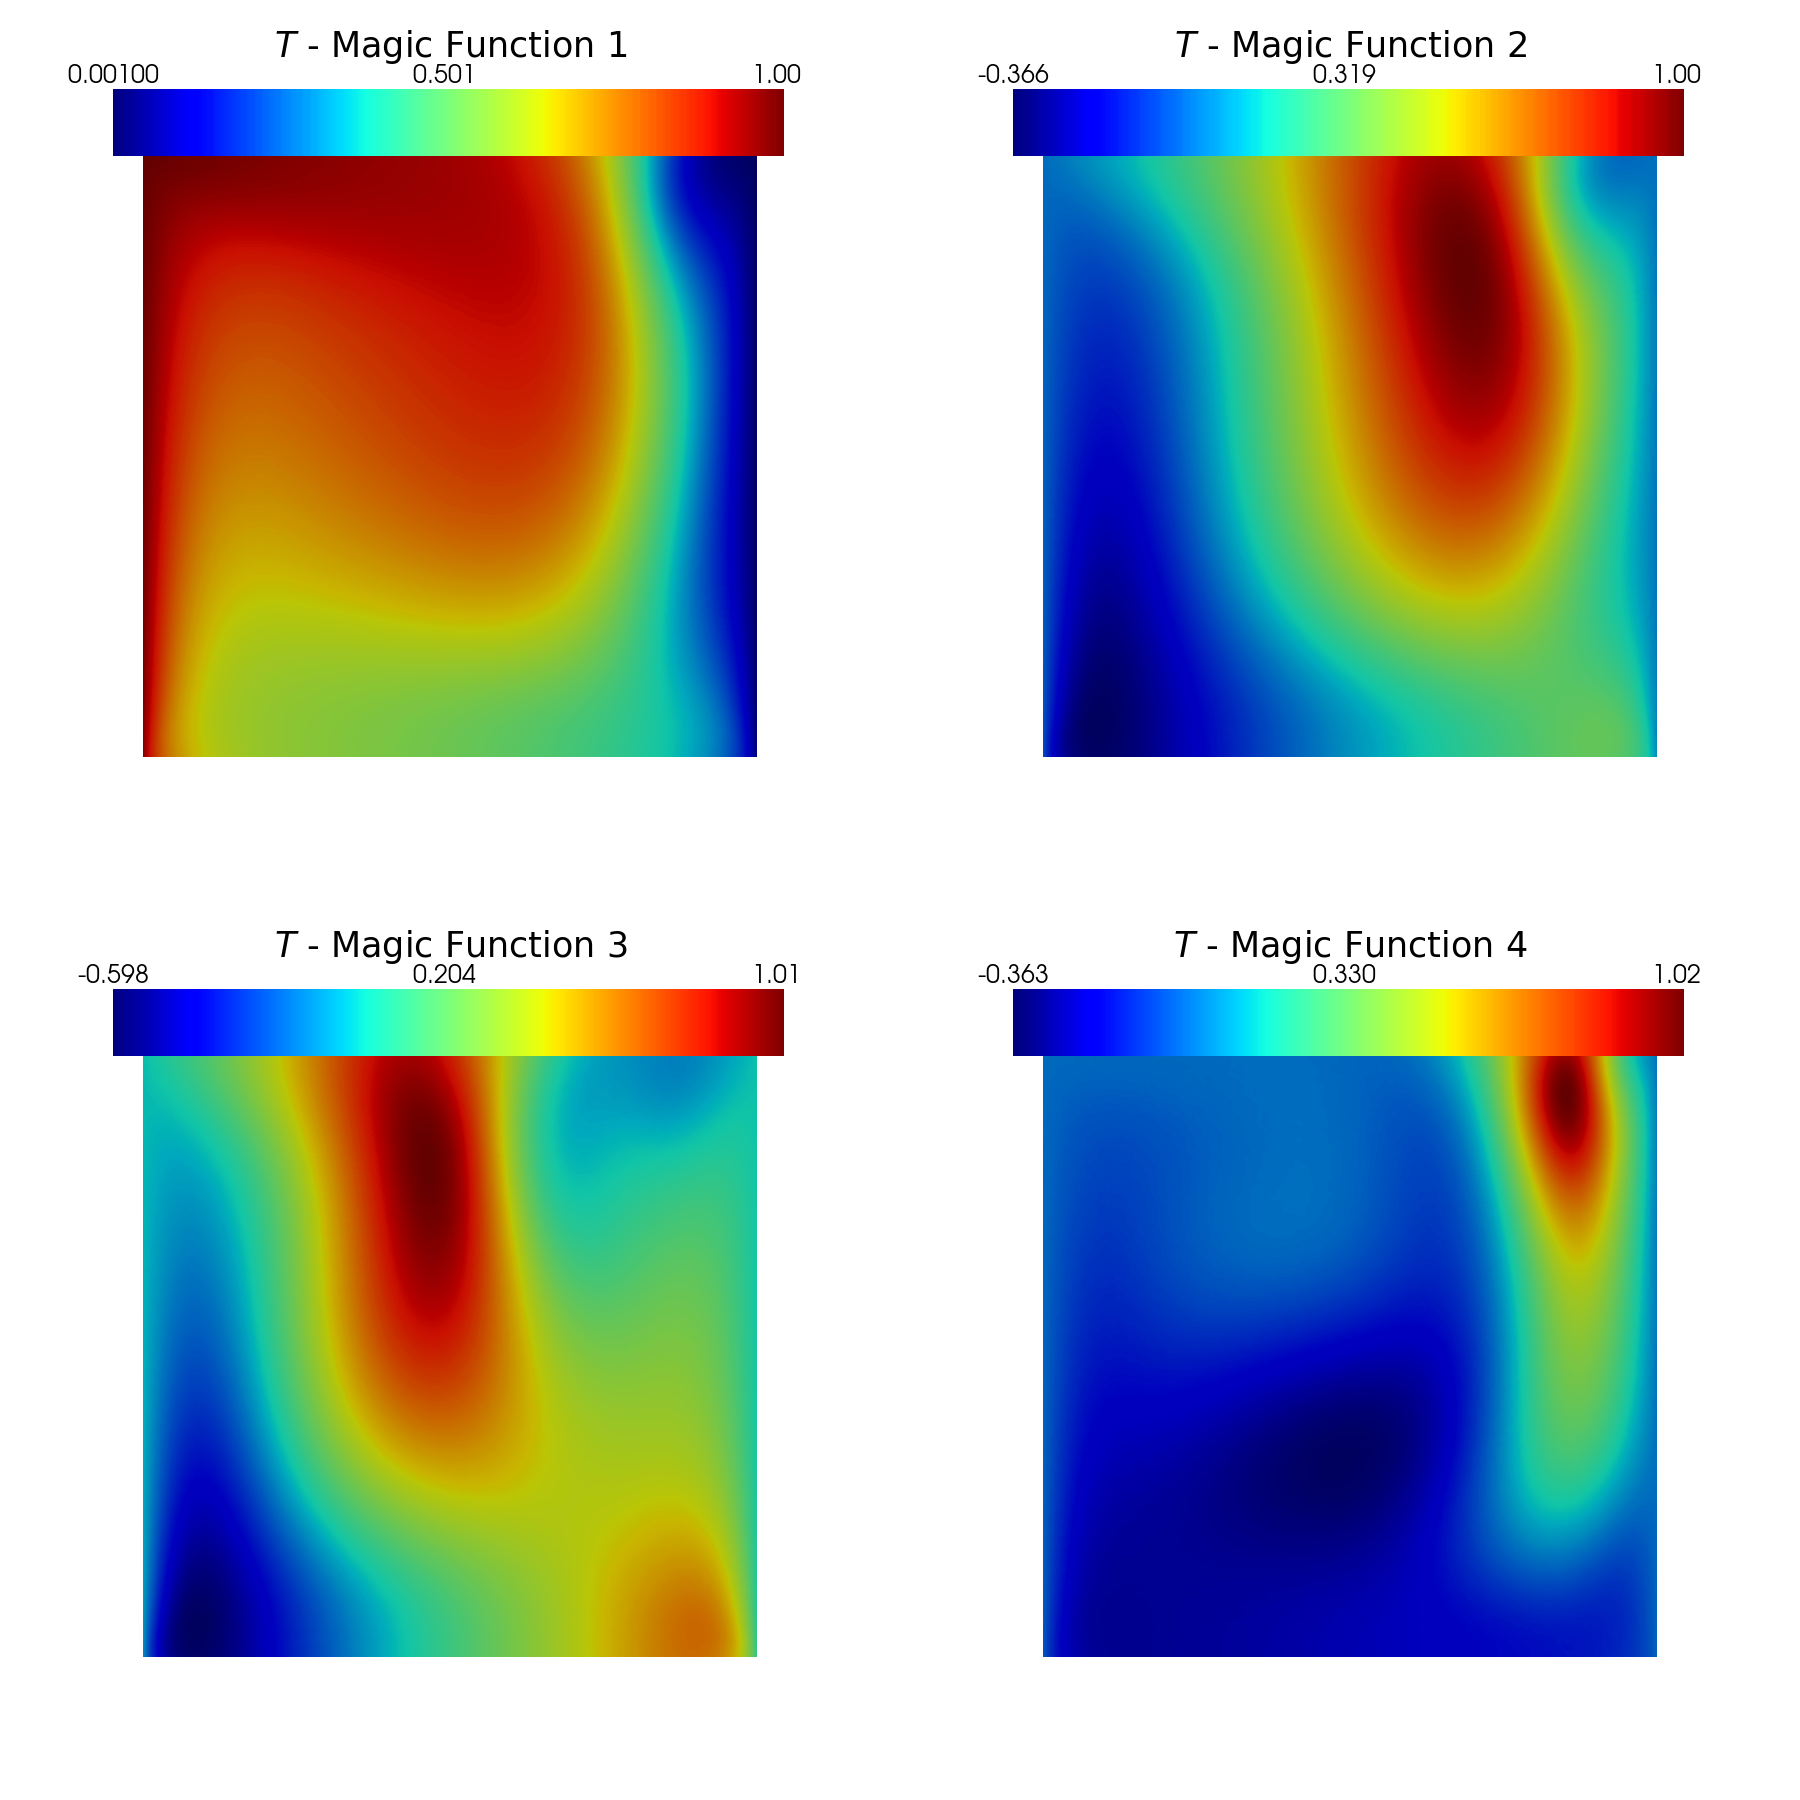

In [8]:
from contour_plotting import plot_modes

plot_modes(geim_data[var_names[0]].magic_fun, tex_var_names[0], 
           shape=[2,2],
           title='Magic Function', zoom=1, subfig_size=[900,900],
           colormap=cm.jet)

Let us also plot the sensors

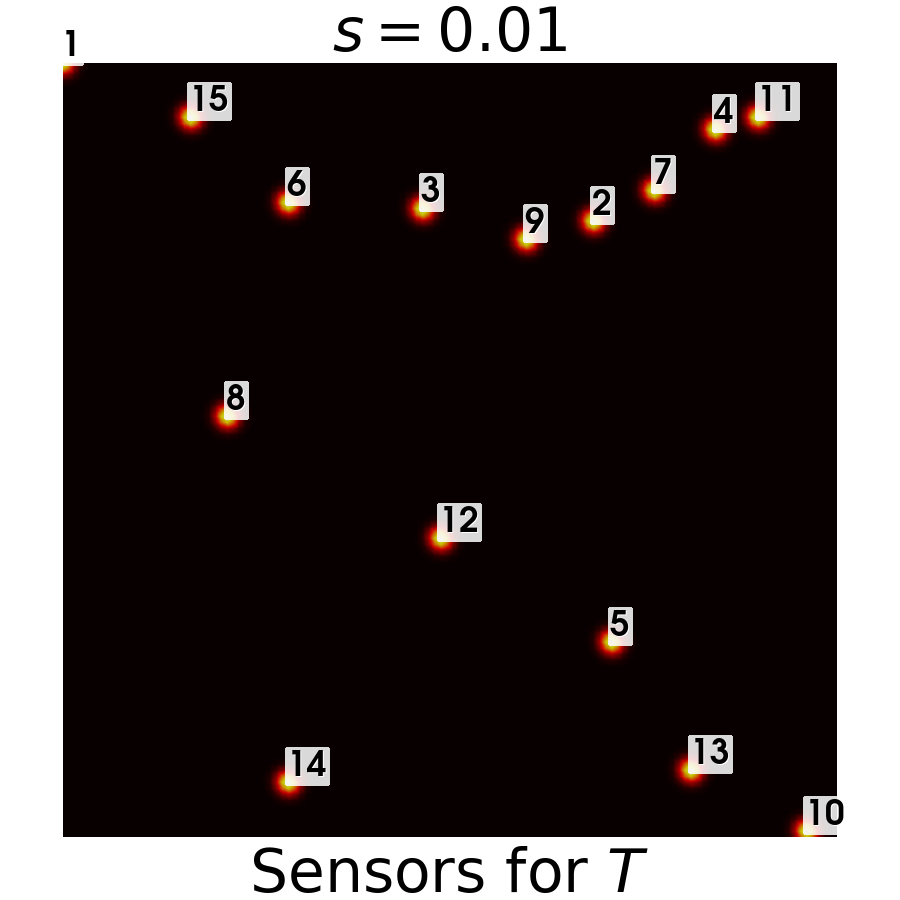

In [15]:
from contour_plotting import plot_geim_sensors

plot_geim_sensors(geim_data['norm_T'], 15, tex_var_names[0], resolution=[900,900])